In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import align

import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import random
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import torch
from torch import nn, optim

/home/eurastof/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Making coordinate data (common atoms)

traj_dirs = ["/wrk/eurastof/binding_spots_project/validation/a2ar_site_*",
             #"/wrk/eurastof/binding_spots_project/validation/d2_site_*",
             "/wrk/eurastof/binding_spots_project/validation/d3_site_*",
             "/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/*"]
#gro_ext = ["/run*/aligned.gro", "/run*/aligned.gro", "/run*/aligned.gro", "/*gro"]
gro_ext = ["/run*/aligned.gro", "/run*/aligned.gro", "/*gro"]
#xtc_ext = ["/run*/aligned.xtc", "/run*/aligned.xtc", "/run*/aligned.xtc", "/*xtc"]
xtc_ext = ["/run*/aligned.xtc", "/run*/aligned.xtc", "/*xtc"]

ndx_files = ["/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/a2ar_common.ndx",
             #"/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d2_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d3_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx"
            ]
#skips = [50, 50, 50, 10]
skips = [50, 50, 10]

ref = mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/step6.6_equilibration.gro")
with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
ref_resids = " ".join(re.findall(r"\d+", lines)[1:])

ids = []

for i, p in  enumerate(traj_dirs):
    print(p)
    skip = skips[i]
    for d in glob.glob(p):
        gro = glob.glob(d + gro_ext[i])[0]
        xtcs = glob.glob(d + xtc_ext[i])
        cosmos = mda.Universe(gro, xtcs)
        mean_length = np.mean([mda.Universe(gro, xtc).trajectory[-1].time/1000000 for xtc in xtcs])
        print(f"Avg. traj. length {mean_length}")     
        for ts in cosmos.trajectory[0:-1:skip]:
            ids.append(i)

np.save("./a2ar_b2ar_d3_ids.npy", np.array(ids))            
coordinates = []

for i, p in  enumerate(traj_dirs):
    
    with open(ndx_files[i]) as f:
        lines = "".join(f.readlines())

    resids = " ".join(re.findall(r"\d+", lines)[1:])
    skip = skips[i]
    
    for d in glob.glob(p):
        gro = glob.glob(d + gro_ext[i])[0]
        xtcs = glob.glob(d + xtc_ext[i])
        
        cosmos = mda.Universe(gro, xtcs)
        common_ca = cosmos.select_atoms(f"bynum {resids}")
        
        for ts in cosmos.trajectory[0:-1:skip]:
            align.alignto(cosmos, ref, select=(f"bynum {resids}", f"bynum {ref_resids}"), tol_mass=100)
            coords = common_ca.positions.flatten()
            coordinates.append(coords.reshape(1, coords.shape[0]))

X = np.concatenate(coordinates)
np.save("./a2ar_b2ar_d3_common_ca_coordinates.npy", X)




## Autoencoder pipeline

In [3]:

class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):

    def __init__(self, in_shape=10, enc_shape=2, middle_shape=5, n_hidden=1, loss_fn=nn.L1Loss(), lr=1e-3):
        
        super().__init__()
        self.loss_fn = loss_fn
        self.lr = lr 
        self.n_hidden = n_hidden # number of hidden layers
        self.in_shape = in_shape # input dimension
        self.enc_shape = enc_shape # dimension of encoding
        self.middle_shape = middle_shape # hidden layer dimensions
        
        encoder_layers = [nn.Linear(self.in_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] # initialize encoder layer list
        decoder_layers = [nn.Linear(self.enc_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] # initialize decoder layer list

        for i in range(n_hidden - 1): # Add layers to encoder and decoder according to n_hidden and middle shape
            encoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(0.2))
            decoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.2))
            
        encoder_layers.append(nn.Linear(self.middle_shape, self.enc_shape)) # Final encoder layer
        decoder_layers.append(nn.Linear(self.middle_shape, self.in_shape)) # Final decoder layer
        #decoder_layers.append(nn.Sigmoid()) # Sigmoid at end of deocder?

        self.encode = nn.Sequential(*encoder_layers) # Make encoder
        self.decode = nn.Sequential(*decoder_layers) # Make decoder
        

    def fit(self, X, y=None, n_epochs=20, batch_size=32, verbose=False):
        self.training = True # Enables e.g. dropouts to work
        X = torch.Tensor(X)
        indices = [i for i in range(X.shape[0])]
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) # Adam only atm
        
        for epoch in range(n_epochs):
        
            random.shuffle(indices) # random shuffle to get random batches for each epoch
            batches = [i for i in range(0, len(indices), batch_size)]

            for i in range(len(batches) - 1):

                batch_X = X[indices[batches[i]:batches[i+1]]]
                self.optimizer.zero_grad() # reset optimizer
                
                encoded = self.encode(batch_X)
                decoded = self.decode(encoded)

                loss = self.loss_fn(decoded, batch_X)
                loss.backward() # Backpropagate
                self.optimizer.step() # Apply changes
            
            if verbose:
                print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
        
        return self

    def transform(self, X, y=None):
        encoded = self.encode(torch.Tensor(X))
        return encoded.cpu().detach().numpy()
    

    def inverse_transform(self, X, y=None):
        decoded = self.decode(torch.Tensor(X))
        return decoded.cpu().detach().numpy()
    
    def score(self, X, y=None):
        encoded = self.transform(X)
        decoded = self.inverse_transform(encoded)
        
        return -self.loss_fn(torch.Tensor(X), torch.Tensor(decoded)) # Take negative to make GridSearchCV work properly
        
    


## Autoencoder testing

In [4]:
#device = ('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # GridSearchCV having issues with GPUs
print(f"Using {device} device.")

Using cpu device.


In [5]:
with open('b2ar_CA_coords.pickle', 'rb') as handle:
    data_dict = pkl.load(handle)

X = np.concatenate([v for k, v in data_dict.items()]) # Input data (CA coordinates)
ids = np.concatenate([[i for i in range(v.shape[0])] for v in data_dict.values()]).reshape(-1,1) # Id for every lipid environment



In [6]:

test = 0.25
index = [_ for _ in range(X.shape[0])]
random.shuffle(index)
test_index = index[:int(test*len(index))]
train_index = index[int(test*len(index)):]
test_X = X[test_index,:]
train_X = X[train_index,:]

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

test_X_scaled = torch.Tensor(scaler.transform(test_X))
test_ids = ids[test_index]
train_X_scaled = torch.Tensor(scaler.transform(train_X))
train_ids = ids[train_index]


In [7]:
encoding_dim = 2
middle_dim = 512
n_hidden = 1

autoencoder = Autoencoder(in_shape=X.shape[1], enc_shape=encoding_dim, middle_shape=middle_dim, n_hidden=n_hidden)
autoencoder.fit(train_X_scaled, n_epochs=3, verbose=True)


epoch 0 	 Loss: 0.6245
epoch 1 	 Loss: 0.6216
epoch 2 	 Loss: 0.627


Autoencoder(in_shape=933, middle_shape=512)

In [8]:
# Test set

encoded = autoencoder.transform(test_X_scaled)
decoded = autoencoder.inverse_transform(torch.Tensor(encoded))
decoded_orig_space = scaler.inverse_transform(decoded)

# L1 loss (Å)

error = np.mean(np.abs(decoded_orig_space - test_X))
print(f"Reconstruction error: {error} Å ")



Reconstruction error: 1.5069377422332764 Å 


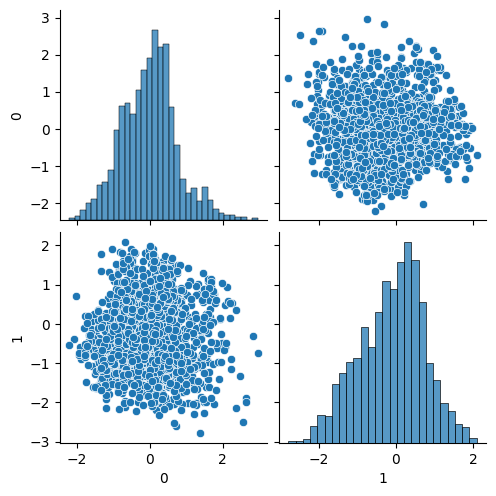

In [9]:
# Encoding scatter

sns.pairplot(pd.DataFrame(encoded))


## Pipeline

In [33]:
# Grid of parameters for gridsearch

param_grid = {
    "Autoencoder":{
        "Autoencoder__middle_shape": [512],
        "Autoencoder__enc_shape": [2],
        "Autoencoder__n_hidden": [1]
    },
    "GMM": {
        "n_components": [4]
    }
}


In [34]:
# Function to search parameters and return best model

def best_pipeline(transformer, param_grid, X, cv=2):
    
    step_names = ["Scaler", "Autoencoder"]
    params = {key: val for k, d in param_grid.items() for key, val in d.items() if k in step_names}
    pipe = Pipeline(
        steps=[
            (step_names[0], StandardScaler()),
            (step_names[1], transformer),
        ]   
    )
    
    gridsearch = GridSearchCV(pipe, param_grid=params, verbose=3, cv=cv)
    gridsearch.fit(X)
    
    return gridsearch.best_estimator_
    

## Pipeline testing

In [39]:
best = best_pipeline(Autoencoder(in_shape=X.shape[1]), param_grid, X)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=1;, score=-0.721 total time=   2.4s
[CV 2/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=1;, score=-0.739 total time=   2.4s


In [41]:
# Test set

encoded = best.transform(test_X)
decoded = best.inverse_transform(torch.Tensor(encoded))

# L1 loss (Å)

error = np.mean(np.abs(decoded- test_X))
print(f"Reconstruction error: {error} Å ")

Reconstruction error: 1.4457952976226807 Å 


In [59]:
# TM36 distance calculation from coordinates

r1 = 99*3
r2 = 240*3
A = test_X[:,r1:r1+3]
B = test_X[:,r2:r2+3]
C = np.array(A - B)

tm36 = np.sqrt(np.sum(C**2, axis=1))


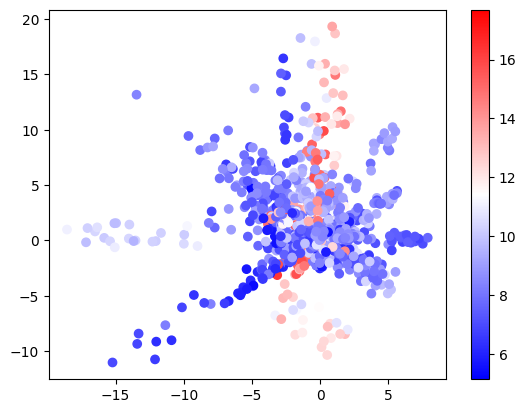

In [60]:
# Plot encoding, color by TM36 value
sc = plt.scatter(encoded[:,0], encoded[:,1], c=tm36, cmap="bwr")
plt.colorbar(sc)
plt.show()


## Input perturbation analysis

In [33]:
from sklearn.utils import shuffle

In [34]:

def IPA(X, model):
        
    
    index = np.arange(0, X.shape[1], 3)
    effects = []
    
    for i in index:
        shuffled = X.copy()
        shuffled = shuffle(shuffled)
        rands = np.random.uniform(low=-5, high=5, size=(shuffled.shape[0],1))
        rands = np.concatenate([rands, rands, rands], axis=1)
        shuffled[:, i:i+3] = rands
        encoded = model.transform(shuffled)
        decoded = model.inverse_transform(encoded)
        decoded = s.inverse_transform(decoded)
        L1 = np.mean(np.abs(X - decoded))
        effects += [L1, L1, L1]
    
    return effects
    
       
eff = IPA(X, best)



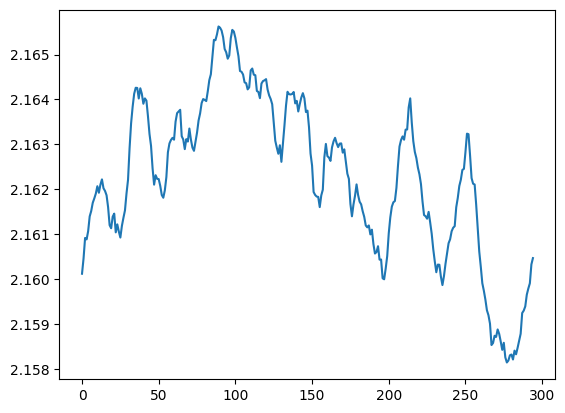

In [35]:
N = 50
E = np.convolve(eff, np.ones(N)/N, mode='valid')

plt.plot(E[0:-1:3])

## Movie creation

cosmos = mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/step6.6_equilibration.gro",
                      "/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/centered_aligned10.xtc")
with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
index = " ".join(re.findall(r"\d+", lines)[1:])
common_ca = cosmos.select_atoms(f"bynum {index}")
common_ca.write("common_ca.gro")

enc_vals = enc[:,1]
n_bins = 10

bins = np.linspace(np.min(enc_vals), np.max(enc_vals), n_bins)

write_file = "enc_dim_2.xtc"


with mda.Writer(write_file, common_ca.n_atoms) as W:
    for i in range(bins.shape[0] - 1):
        
        in_bin = np.where((enc_vals > bins[i]) & (enc_vals < bins[i + 1]))[0]
        
        frames_in_bin = np.array(X[in_bin,:])
        avg_frame_in_bin = np.mean(frames_in_bin, axis=0).reshape(1, frames_in_bin.shape[1])
        distances_to_avg = np.mean(np.sqrt((frames_in_bin - avg_frame_in_bin)**2), axis=1)
        closest = np.argmin(distances_to_avg)
        closest_coords = frames_in_bin[closest,:].reshape(int(frames_in_bin.shape[1]/3), 3)
        common_ca.positions = closest_coords
        W.write(common_ca)
    
    
    



## Visual Check

In [16]:
AE = Autoencoder(in_shape=X.shape[1], middle_shape=1024, n_hidden=1)
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(train_X)
X_test_scaled = scaler.transform(test_X)
AE.fit(X_train_scaled, verbose=True, n_epochs=3)

epoch 0 	 Loss: 0.5608
epoch 1 	 Loss: 0.6359
epoch 2 	 Loss: 0.6555


Autoencoder(in_shape=933, middle_shape=1024)

In [22]:
from MDAnalysis.analysis.distances import distance_array

In [25]:
# Finding frames with minimium and maximum TM36
ref = mda.Universe("../binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/chol-site-3/step6.6_equilibration.gro", 
                   sorted(glob.glob("../binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/chol-site-3/centered_aligned*.xtc")))
tm36 = []
for ts in ref.trajectory:
    d = distance_array(ref.select_atoms("resid 100 and name CA").positions,
                   ref.select_atoms("resid 241 and name CA").positions)[0][0]
    tm36.append(d)
    
tm36 = np.array(tm36)
print(f"frame with max tm36: {np.argmax(tm36)}, min: {np.argmin(tm36)}")


frame with max tm36: 2606, min: 1004


In [58]:
ref.trajectory[1004]
cas = ref.select_atoms("name CA")
pos = cas.positions.flatten().reshape(1, 933)
cas.write("./b2ar_small_tm36.gro")

pos_scaled = scaler.transform(pos)
encoded = torch.Tensor(AE.transform(pos_scaled))
decoded = AE.inverse_transform(encoded)
decoded = scaler.inverse_transform(decoded)
print(np.sqrt(np.mean((decoded - pos)**2)))
o = []
for i in range(0, decoded.shape[1], 3):
    o.append(decoded[:,i:i+3])
decoded = np.concatenate(o, axis=0)
cas.positions = decoded
cas.write("./b2ar_small_tm36_reconstructed.gro")

ref.trajectory[2606]
cas = ref.select_atoms("name CA")
pos = cas.positions.flatten().reshape(1, 933)
cas.write("./b2ar_large_tm36.gro")

pos_scaled = scaler.transform(pos)
encoded = torch.Tensor(AE.transform(pos_scaled))
decoded = AE.inverse_transform(encoded)
decoded = scaler.inverse_transform(decoded)
print(np.sqrt(np.mean((decoded - pos)**2)))
o = []
for i in range(0, decoded.shape[1], 3):
    o.append(decoded[:,i:i+3])
decoded = np.concatenate(o, axis=0)
cas.positions = decoded
cas.write("./b2ar_large_tm36_reconstructed.gro")

3.4373217
4.33043
